# QuanEstimation : single parameter estimation

We consider a system whose Hamiltonian is $H = \frac{1}{2}\omega_0 \sigma_z$, where $\sigma_z$ is a Pauli matrix.

The dynamics of the system is governed by
$\partial_t\rho=-i[H, \rho]+ \frac{\gamma}{2}(\sigma_z\rho\sigma_z-\rho)$.

Preparing the probe state at $|+\rangle$, the final state at $T$ in the Bloch representation is given by $\vec{r}(T)=(r_1(T),r_2(T),r_3(T))$ with

$r_1(T)=e^{-\gamma T}\sin(\omega_0 \Delta t)\sin(\omega_0 t_0) $,

$r_2(T)=e^{-\gamma T}\cos(\omega_0 \Delta t)\sin(\omega_0 t_0) $,

$r_3(T)=e^{-\gamma t_0}\sin(\omega_0 t_0) $,

and $\Delta t$ is the time step.

We can obtain the QFI 

$F(T) = e^{-2\gamma t_0}t_0^2 \sin^2 (\omega_0 t_0) + e^{-2\gamma T}[t_0^2+T(T-2t_0)\sin^2(\omega_0 t_0)] 
      + \frac{t_0^2(e^{-2\gamma T}-e^{-2\gamma t_0})^2\sin^2(\omega_0 t_0) \cos^2(\omega_0 t_0)}
          {1-e^{-2\gamma T}\sin^2(\omega_0 t_0)-e^{-2\gamma t_0} \cos^2(\omega_0 t_0)}$.

The measurement for CFI is $\{|+\rangle\langle+|, |-\rangle\langle-|\}$.

$\textbf{References}$

[1] J. Liu and H. Yuan, Phys. Rev. A $\textbf{96}$, 012117 (2017).

In [1]:
%reset -f
import numpy as np
from scipy import linalg as scylin
import matplotlib.pyplot as plt
from julia.api import Julia
jl = Julia(compiled_modules=False)
import julia
from julia import Main

from AsymptoticBound.CramerRao import QFIM, CFIM
from Common.common import mat_vec_convert, dRHO

Main.include('./'+'Common'+'/'+'Liouville.jl')

omega0 = 1.0
gamma_p = 0.05
T = 30.0
dt = 0.01
tnum = int(T/dt)
sx = np.array([[0.+0.j, 1.+0.j],[1.+0.j, 0.+0.j]])  
sy = np.array([[0.+0.j, 0.-1.j],[0.+1.j, 0.+0.j]]) 
sz = np.array([[1.+0.j, 0.+0.j],[0.+0.j, -1.+0.j]])
sp, sm = 0.5*(sx+1j*sy), 0.5*(sx-1j*sy)

#initial state
psi0 = np.array([[1.+0.j],[0.+0.j]])
psi1 = np.array([[0.+0.j],[1.+0.j]])
psi_p = (psi0+psi1)/np.sqrt(2)
psi_m = (psi0-psi1)/np.sqrt(2)
rho0 = np.dot(psi_p, psi_p.conj().T)
dim = len(rho0)

#time independent Hamiltonian
H = 0.5*omega0*sz
dH = 0.5*sz

# Hilbert space to liouvillian
H_L = Main.Liouville.liouville_commu(H)
dH_L = Main.Liouville.liouville_commu(dH)
sz_L  = Main.Liouville.liouville_dissip(sz)

#measurement
M1 = np.dot(psi_p, psi_p.conj().transpose())
M2 = np.dot(psi_m, psi_m.conj().transpose())
M  = [M1, M2]

state_pre = mat_vec_convert(rho0)
d_state = np.array([[0.+0.*1.j] for i in range(0,dim**2)])
Liouv_tot = -1j*H_L + gamma_p*sz_L

cfi = []
qfi = []
for ti in range(tnum):
     
    state = np.dot(scylin.expm(dt*Liouv_tot), state_pre)
    rho = mat_vec_convert(state)
    
    A = -1j*np.dot(dH_L, state_pre)
    d_state = dRHO(d_state, Liouv_tot, A, dt)
    
    d_rho = mat_vec_convert(d_state)
    drho = [d_rho]
    F_cl = CFIM(rho, drho, M)
    F_q = QFIM(rho, drho)
    state_pre = state
    
    cfi.append(F_cl)
    qfi.append(F_q)

plt.plot(np.linspace(0, T, tnum), qfi, 'r-', linewidth=2.5, label='QFI')
plt.plot(np.linspace(0, T, tnum), cfi, 'g--', linewidth=2.5, label='CFI')
plt.xlabel('$t$',fontsize=20)
plt.axis([0, 30., 0, 15])
plt.xticks([0,10,20,30],fontsize=15)
plt.yticks([0,5,10,15],fontsize=15)
plt.legend(bbox_to_anchor = [1.0, 1.0], frameon=False,fontsize=15)
#plt.savefig('test_qfi.pdf',bbox_inches = 'tight')
plt.show()

FileNotFoundError: [WinError 2] 系统找不到指定的文件。

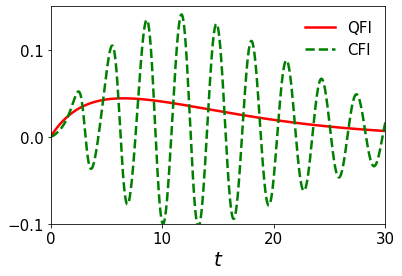

In [48]:
qfi_pro = np.load('qfi_pro.npy')
cfi_pro = np.load('cfi_pro.npy')
plt.plot(np.linspace(0, T, tnum), qfi-qfi_pro, 'r-', linewidth=2.5, label='QFI')
plt.plot(np.linspace(0, T, tnum), cfi-cfi_pro, 'g--', linewidth=2.5, label='CFI')
plt.xlabel('$t$',fontsize=20)
plt.axis([0, 30., -0.08,0.15])
plt.xticks([0,10,20,30],fontsize=15)
plt.yticks([-0.1,0,0.1],fontsize=15)
plt.legend(bbox_to_anchor = [1.0, 1.0], frameon=False,fontsize=15)
#plt.savefig('test_qfi.pdf',bbox_inches = 'tight')
plt.show()

Calculate $\rho$ and $\partial_x \rho$ with propagator

In [2]:
%reset -f
import numpy as np
from scipy import linalg as scylin
import matplotlib.pyplot as plt
from qutip import Qobj,liouvillian,mat2vec,qeye

from AsymptoticBound.CramerRao import QFIM,CFIM
from Dynamics.dynamics import Lindblad
from Common.common import mat_vec_convert, dRHO

omega0 = 1.0
gamma = [0.05] 
T = 30
dt = 0.01
tnum = int(T/dt)
times = np.linspace(0, T, tnum)
sx = np.array([[0.+0.j, 1.+0.j],[1.+0.j, 0.+0.j]])  
sy = np.array([[0.+0.j, 0.-1.j],[0.+1.j, 0.+0.j]]) 
sz = np.array([[1.+0.j, 0.+0.j],[0.+0.j, -1.+0.j]])
sp, sm = 0.5*(sx+1j*sy), 0.5*(sx-1j*sy)

#initial state
psi0 = np.array([[1.+0.j],[0.+0.j]])
psi1 = np.array([[0.+0.j],[1.+0.j]])
psi_p = (psi0+psi1)/np.sqrt(2)
psi_m = (psi0-psi1)/np.sqrt(2)
rho0 = np.dot(psi_p, psi_p.conj().T)
dim = len(rho0)

#measurement
M1 = np.dot(psi_p, psi_p.conj().transpose())
M2 = np.dot(psi_m, psi_m.conj().transpose())
M  = [M1, M2]

#time independent Hamiltonian
H0 = 0.5*omega0*sz
dH = [0.5*sz]
Liouville_operator = [sz]

dynamics = Lindblad(times, rho0, H0, [], dH, [], Liouville_operator, gamma, control_option=False)
dynamics.data_generation()
rho =  dynamics.rho
drho = dynamics.rho_derivative

cfi = []
qfi = []
for ti in range(tnum):
    rho_ = mat_vec_convert(rho[ti])
    drho_tp = mat_vec_convert(drho[ti][0])
    drho_ = [drho_tp]
    F_cl = CFIM(rho_, drho_, M)
    F_q = QFIM(rho_, drho_)
    
    cfi.append(F_cl)
    qfi.append(F_q)
    
plt.plot(np.linspace(0, T, tnum), qfi, 'r-', linewidth=2.5, label='QFI')
plt.plot(np.linspace(0, T, tnum), cfi, 'g--', linewidth=2.5, label='CFI')
plt.xlabel('$t$',fontsize=20)
plt.axis([0, 30., 0, 15])
plt.xticks([0,10,20,30],fontsize=15)
plt.yticks([0,5,10,15],fontsize=15)
plt.legend(bbox_to_anchor = [1.0, 1.0], frameon=False,fontsize=15)
#plt.savefig('test_qfi.pdf',bbox_inches = 'tight')
plt.show()

ModuleNotFoundError: No module named 'qutip'

In [39]:
np.save('qfi_pro.npy',qfi)
np.save('cfi_pro.npy',cfi)

# QuanEstimation: multi-parameter estimation
We consider a system whose dynamics can be described by the master equation $\partial_t\rho=-i[H, \rho]+\sum_{i=1}^2 \frac{\gamma_i}{2}(\sigma_i^z\rho\sigma_i^z-\rho)$,

where $H = -x_1(\sigma_1^x\sigma_2^x+\sigma_1^y\sigma_2^y)-x_2(\sigma_1^z\sigma_2^z)$, with $\sigma_1^{(i)}=\sigma_i \otimes \mathrm{I}_2,
\sigma_2^{(i)} = \mathrm{I}_2 \otimes \sigma_i$ and $\sigma_i$ is Pauli matrix, $\mathrm{I}_2$ denotes the $2\times2$ identity matrix.

The QFIM can be calculated as (in the basis $\{x_1, x_2\}$)

$F_q = 4 \left(\begin{matrix} 2 T^2 & 0 \\ 0 & T^2 \end{matrix} \right)$,

with the optimal probe state is $|\psi_0\rangle = \frac{1}{\sqrt 2}|0\rangle(|0\rangle+i|1\rangle)$.

Now we perform a practical measurement$\{|++\rangle\langle++|, |+-\rangle\langle+-|, |-+\rangle\langle-+|, |--\rangle\langle--|\}$,

and calculate the corresponding CFIM (in the basis $\{x_1, x_2\}$), 

$F_{cl} = 4 \left(\begin{matrix}  T^2 & 0 \\ 0 & T^2 \end{matrix} \right)$, for unitary dynamics, 

and $F_{cl} = 2T^2 \left(\begin{matrix} \delta_+ + \delta_- & \delta_+ - \delta_- \\ \delta_+ - \delta_- & \delta_+ + \delta_ - \end{matrix} \right)$for noisy scenario, where
$\delta_{\pm} := \frac{\cos^2[2T(x_1\pm x_2)]}{e^{2\gamma T} - \sin^2[2T(x_1\pm x_2)]}$.

$\textbf{References}$

[1] J. Liu and H. Yuan, Phys. Rev. A $\textbf{96}$, 042114 (2017).

In [56]:
%reset -f
import numpy as np
from scipy import linalg as scylin
import numpy.linalg as LA
import matplotlib.pyplot as plt
import julia
from julia import Main

from AsymptoticBound.CramerRao import QFIM, CFIM
from Common.common import mat_vec_convert, dRHO

Main.include('./'+'Common'+'/'+'Liouville.jl')

x1 = 1.0
x2 = 1.2
gamma1 = 0.01
gamma2 = 0.01
gamma = [gamma1, gamma2]
T = 10
dt = 0.001
tnum = int(T/dt)
sx = np.array([[0.+0.j, 1.+0.j],[1.+0.j, 0.+0.j]])  
sy = np.array([[0.+0.j, 0.-1.j],[0.+1.j, 0.+0.j]]) 
sz = np.array([[1.+0.j, 0.+0.j],[0.+0.j, -1.+0.j]])
ide = np.array([[1.+0.j,0.+0.j],[0.+0.j,1.+0.j]])   
sx1, sx2 = np.kron(sx,ide), np.kron(ide,sx)
sy1, sy2 = np.kron(sy,ide), np.kron(ide,sy)
sz1, sz2 = np.kron(sz,ide), np.kron(ide,sz)

#initial state
psi0 = np.array([[1.+0.j],[0.+0.j]])
psi1 = np.array([[0.+0.j],[1.+0.j]])
psi = (np.kron(psi0,(psi0+1j*psi1)))/np.sqrt(2)
rho0 = np.dot(psi, psi.conj().T)
dim = len(rho0)

#time independent Hamiltonian
H = -x1*(np.dot(sx1,sx2)+np.dot(sy1,sy2))-x2*np.dot(sz1,sz2)
dH_1 = -(np.dot(sx1,sx2)+np.dot(sy1,sy2))
dH_2 = -np.dot(sz1,sz2)

H_L = Main.Liouville.liouville_commu(H)
dH1_L = Main.Liouville.liouville_commu(dH_1)
dH2_L = Main.Liouville.liouville_commu(dH_2)
sz1_L  = Main.Liouville.liouville_dissip(sz1)
sz2_L  = Main.Liouville.liouville_dissip(sz2)

#measurement
psi_p = (psi0+psi1)/np.sqrt(2)
psi_m = (psi0-psi1)/np.sqrt(2)
M1 = np.dot(np.kron(psi_p,psi_p), np.kron(psi_p,psi_p).conj().transpose())
M2 = np.dot(np.kron(psi_p,psi_m), np.kron(psi_p,psi_m).conj().transpose())
M3 = np.dot(np.kron(psi_m,psi_p), np.kron(psi_m,psi_p).conj().transpose())
M4 = np.dot(np.kron(psi_m,psi_m), np.kron(psi_m,psi_m).conj().transpose())
M  = [M1, M2, M3, M4]

state_pre = mat_vec_convert(rho0)
dstate_1 = np.array([[0.+0.*1.j] for i in range(0,dim**2)])
dstate_2 = np.array([[0.+0.*1.j] for i in range(0,dim**2)])

cfim = []
qfim = []
for ti in range(tnum):
    Liouv_tot = -1j*H_L + gamma1*sz1_L + gamma2*sz2_L
    state = np.dot(scylin.expm(dt*Liouv_tot), state_pre)
    
    A1 = -1j*np.dot(dH1_L, state_pre)
    A2 = -1j*np.dot(dH2_L, state_pre)
    dstate_1 = dRHO(dstate_1, Liouv_tot, A1, dt)
    dstate_2 = dRHO(dstate_2, Liouv_tot, A2, dt)

    rho = mat_vec_convert(state)
    drho_1 = mat_vec_convert(dstate_1)
    drho_2 = mat_vec_convert(dstate_2)


    drho = [drho_1, drho_2]
    F_cl = CFIM(rho, drho, M)
    F_q = QFIM(rho, drho)
    state_pre = state
    
    cfim.append(F_cl)
    qfim.append(F_q)
    
fc00 = [cfim[i][0][0] for i in range(tnum)]
fc01 = [cfim[i][0][1] for i in range(tnum)]
fc10 = [cfim[i][1][0] for i in range(tnum)]
fc11 = [cfim[i][1][1] for i in range(tnum)]

Fq00 = [qfim[i][0][0] for i in range(tnum)]
Fq01 = [qfim[i][0][1] for i in range(tnum)]
Fq10 = [qfim[i][1][0] for i in range(tnum)]
Fq11 = [qfim[i][1][1] for i in range(tnum)]

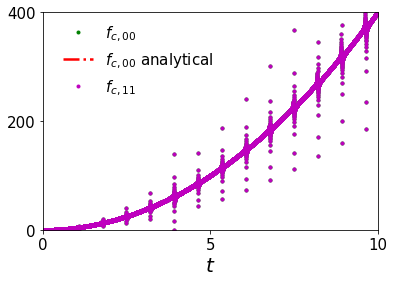

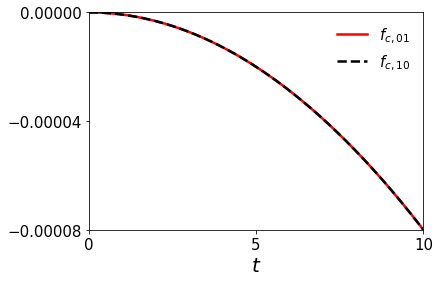

In [54]:
#===============================unitary==========================================
plt.plot(np.linspace(0, T, tnum), fc00, 'g.', linewidth=2.5, label='$f_{c,00}$')
plt.plot(np.linspace(0, T, tnum), 4*np.linspace(0, T, tnum)**2, 'r-.', linewidth=2.5, label='$f_{c,00}~$analytical')
plt.plot(np.linspace(0, T, tnum), fc11, 'm.', linewidth=2.5, label='$f_{c,11}$')
plt.xlabel('$t$',fontsize=20)
plt.axis([0, 10., 0, 400])
plt.xticks([0,5,10],fontsize=15)
plt.yticks([0,200,400],fontsize=15)
plt.legend(bbox_to_anchor = [0.550, 0.55], frameon=False,fontsize=15)
#plt.savefig('test_qfi.pdf',bbox_inches = 'tight')
plt.show()

plt.plot(np.linspace(0, T, tnum), Fq01, 'r-', linewidth=2.5, label='$f_{c,01}$')
plt.plot(np.linspace(0, T, tnum), Fq10, 'k--', linewidth=2.5, label='$f_{c,10}$')
plt.xlabel('$t$',fontsize=20)
plt.axis([0, 10., -0.00008, 0])
plt.xticks([0,5,10],fontsize=15)
plt.yticks([-0.00008, -0.00004,0],fontsize=15)
plt.legend(bbox_to_anchor = [1.0, 1.0], frameon=False,fontsize=15)
plt.show()

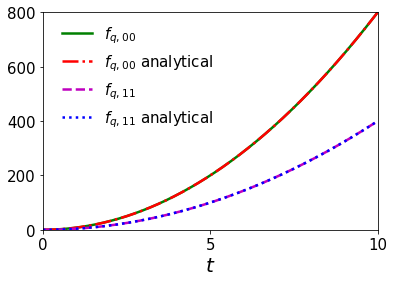

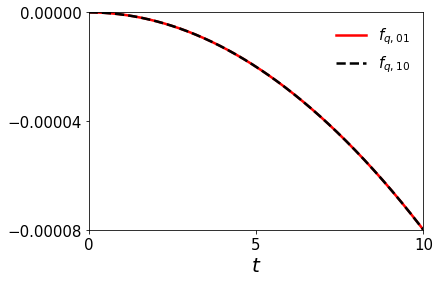

In [55]:
#==========================unitary======================================
plt.plot(np.linspace(0, T, tnum), Fq00, 'g-', linewidth=2.5, label='$f_{q,00}$')
plt.plot(np.linspace(0, T, tnum), 8*np.linspace(0, T, tnum)**2, 'r-.', linewidth=2.5, label='$f_{q,00}~$analytical')
plt.plot(np.linspace(0, T, tnum), Fq11, 'm--', linewidth=2.5, label='$f_{q,11}$')
plt.plot(np.linspace(0, T, tnum), 4*np.linspace(0, T, tnum)**2, 'b:', linewidth=2.5, label='$f_{q,11}~$analytical')

plt.xlabel('$t$',fontsize=20)
plt.axis([0, 10., 0, 800])
plt.xticks([0,5,10],fontsize=15)
plt.yticks([0,200,400,600,800],fontsize=15)
plt.legend(bbox_to_anchor = [0.55, 0.40], frameon=False,fontsize=15)
#plt.savefig('test_qfi.pdf',bbox_inches = 'tight')
plt.show()

plt.plot(np.linspace(0, T, tnum), Fq01, 'r-', linewidth=2.5, label='$f_{q,01}$')
plt.plot(np.linspace(0, T, tnum), Fq10, 'k--', linewidth=2.5, label='$f_{q,10}$')
plt.xlabel('$t$',fontsize=20)
plt.axis([0, 10., -0.00008, 0])
plt.xticks([0,5,10],fontsize=15)
plt.yticks([-0.00008, -0.00004,0],fontsize=15)
plt.legend(bbox_to_anchor = [1.0, 1.0], frameon=False,fontsize=15)
plt.show()

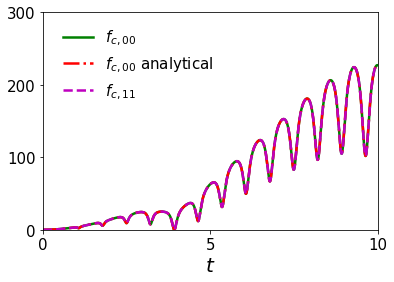

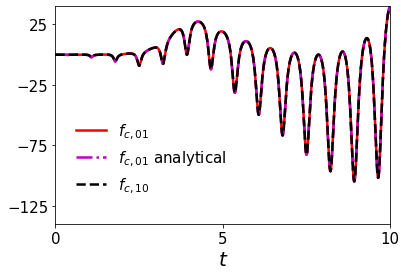

In [57]:
#====================================noisy===============================
# analytical solution
gamma = 2*gamma1
delta_p = lambda t: np.cos(2*t*(x1+x2))**2/(np.exp(2*gamma*t)-np.sin(2*t*(x1+x2))**2)
delta_m = lambda t: np.cos(2*t*(x1-x2))**2/(np.exp(2*gamma*t)-np.sin(2*t*(x1-x2))**2)
t = np.linspace(0, T, tnum)
plt.plot(np.linspace(0, T, tnum), fc00, 'g-', linewidth=2.5, label='$f_{c,00}$')
plt.plot(np.linspace(0, T, tnum), 2*t**2*(delta_p(t)+delta_m(t)), 'r-.', linewidth=2.5, label='$f_{c,00}~$analytical')
plt.plot(np.linspace(0, T, tnum), fc11, 'm--', linewidth=2.5, label='$f_{c,11}$')

plt.xlabel('$t$',fontsize=20)
plt.axis([0, 10., 0, 300])
plt.xticks([0,5,10],fontsize=15)
plt.yticks([0,100,200,300],fontsize=15)
plt.legend(bbox_to_anchor = [0.55, 0.53], frameon=False,fontsize=15)
plt.show()

plt.plot(np.linspace(0, T, tnum), fc01, 'r-', linewidth=2.5, label='$f_{c,01}$')
plt.plot(np.linspace(0, T, tnum), 2*t**2*(delta_p(t)-delta_m(t)), 'm-.', linewidth=2.5, label='$f_{c,01}~$analytical')
plt.plot(np.linspace(0, T, tnum), fc10, 'k--', linewidth=2.5, label='$f_{c,10}$')

plt.xlabel('$t$',fontsize=20)
plt.axis([0, 10., -140, 40])
plt.xticks([0,5,10],fontsize=15)
plt.yticks([-125, -75,-25,25],fontsize=15)
plt.legend(bbox_to_anchor = [0.55, 0.53], frameon=False,fontsize=15)
plt.show()


In [61]:
%reset -f
import numpy as np
from scipy import linalg as scylin
import matplotlib.pyplot as plt
from qutip import Qobj,liouvillian,mat2vec,qeye

from AsymptoticBound.CramerRao import QFIM, CFIM
from Dynamics.dynamics import Lindblad
from Common.common import mat_vec_convert, dRHO

x1 = 1.0
x2 = 1.2
gamma1 = 0.01
gamma2 = 0.01
gamma = [gamma1, gamma2]
T = 10
dt = 0.004
tnum = int(T/dt)
times = np.linspace(0, T, tnum)

sx = np.array([[0.+0.j, 1.+0.j],[1.+0.j, 0.+0.j]])  
sy = np.array([[0.+0.j, 0.-1.j],[0.+1.j, 0.+0.j]]) 
sz = np.array([[1.+0.j, 0.+0.j],[0.+0.j, -1.+0.j]])
ide = np.array([[1.+0.j,0.+0.j],[0.+0.j,1.+0.j]])   
sx1, sx2 = np.kron(sx,ide), np.kron(ide,sx)
sy1, sy2 = np.kron(sy,ide), np.kron(ide,sy)
sz1, sz2 = np.kron(sz,ide), np.kron(ide,sz)

#initial state
psi0 = np.array([[1.+0.j],[0.+0.j]])
psi1 = np.array([[0.+0.j],[1.+0.j]])
psi = (np.kron(psi0,(psi0+1j*psi1)))/np.sqrt(2)
rho0 = np.dot(psi, psi.conj().T)
dim = len(rho0)

#time independent Hamiltonian
H0 = -x1*(np.dot(sx1,sx2)+np.dot(sy1,sy2))-x2*np.dot(sz1,sz2)
dH1 = -(np.dot(sx1,sx2)+np.dot(sy1,sy2))
dH2 = -np.dot(sz1,sz2)
dH = [dH1, dH2]

#measurement
psi_p = (psi0+psi1)/np.sqrt(2)
psi_m = (psi0-psi1)/np.sqrt(2)
M1 = np.dot(np.kron(psi_p,psi_p), np.kron(psi_p,psi_p).conj().transpose())
M2 = np.dot(np.kron(psi_p,psi_m), np.kron(psi_p,psi_m).conj().transpose())
M3 = np.dot(np.kron(psi_m,psi_p), np.kron(psi_m,psi_p).conj().transpose())
M4 = np.dot(np.kron(psi_m,psi_m), np.kron(psi_m,psi_m).conj().transpose())
M  = [M1, M2, M3, M4]

Liouville_operator = [sz1, sz2]

dynamics = Lindblad(times, rho0, H0, [], dH, [], Liouville_operator, gamma, control_option=False)
dynamics.data_generation()
rho =  dynamics.rho
drho = dynamics.rho_derivative

cfim = []
qfim = []
for ti in range(tnum):
    rho_ = mat_vec_convert(rho[ti])
    drho_ = [0. for i in range(len(dH))]
    for i in range(len(dH)):
        drho_tp = mat_vec_convert(drho[ti][i])
        drho_[i] = drho_tp
    F_cl = CFIM(rho_, drho_, M)
    F_q = QFIM(rho_, drho_)
    
    cfim.append(F_cl)
    qfim.append(F_q)
Fq00 = [qfim[i][0][0] for i in range(tnum)]
Fq01 = [qfim[i][0][1] for i in range(tnum)]
Fq10 = [qfim[i][1][0] for i in range(tnum)]
Fq11 = [qfim[i][1][1] for i in range(tnum)]

fc00 = [cfim[i][0][0] for i in range(tnum)]
fc01 = [cfim[i][0][1] for i in range(tnum)]
fc10 = [cfim[i][1][0] for i in range(tnum)]
fc11 = [cfim[i][1][1] for i in range(tnum)]

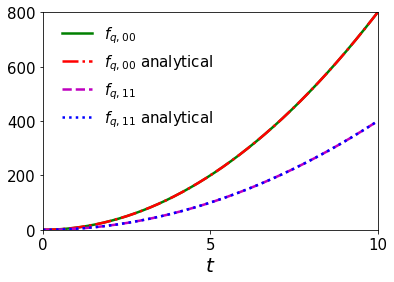

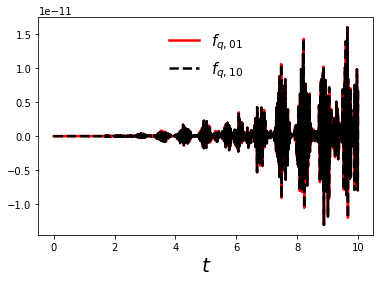

In [59]:
#======================unitary====================================
plt.plot(np.linspace(0, T, tnum), Fq00, 'g-', linewidth=2.5, label='$f_{q,00}$')
plt.plot(np.linspace(0, T, tnum), 8*np.linspace(0, T, tnum)**2, 'r-.', linewidth=2.5, label='$f_{q,00}~$analytical')
plt.plot(np.linspace(0, T, tnum), Fq11, 'm--', linewidth=2.5, label='$f_{q,11}$')
plt.plot(np.linspace(0, T, tnum), 4*np.linspace(0, T, tnum)**2, 'b:', linewidth=2.5, label='$f_{q,11}~$analytical')

plt.xlabel('$t$',fontsize=20)
plt.axis([0, 10., 0, 800])
plt.xticks([0,5,10],fontsize=15)
plt.yticks([0,200,400,600,800],fontsize=15)
plt.legend(bbox_to_anchor = [0.55, 0.40], frameon=False,fontsize=15)
#plt.savefig('test_qfi.pdf',bbox_inches = 'tight')
plt.show()

plt.plot(np.linspace(0, T, tnum), Fq01, 'r-', linewidth=2.5, label='$f_{q,01}$')
plt.plot(np.linspace(0, T, tnum), Fq10, 'k--', linewidth=2.5, label='$f_{q,10}$')
plt.xlabel('$t$',fontsize=20)
#plt.axis([0, 10., -0.00008, 0])
#plt.xticks([0,5,10],fontsize=15)
#plt.yticks([-0.00008, -0.00004,0],fontsize=15)
plt.legend(bbox_to_anchor = [0.65, 0.65], frameon=False,fontsize=15)
plt.show()

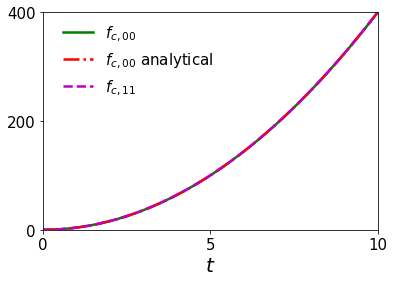

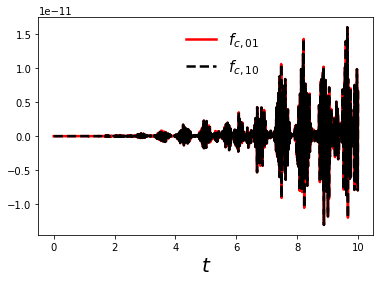

In [60]:
#======================unitary====================================
plt.plot(np.linspace(0, T, tnum), fc00, 'g-', linewidth=2.5, label='$f_{c,00}$')
plt.plot(np.linspace(0, T, tnum), 4*np.linspace(0, T, tnum)**2, 'r-.', linewidth=2.5, label='$f_{c,00}~$analytical')
plt.plot(np.linspace(0, T, tnum), fc11, 'm--', linewidth=2.5, label='$f_{c,11}$')
plt.xlabel('$t$',fontsize=20)
plt.axis([0, 10., 0, 400])
plt.xticks([0,5,10],fontsize=15)
plt.yticks([0,200,400],fontsize=15)
plt.legend(bbox_to_anchor = [0.55, 0.550], frameon=False,fontsize=15)
#plt.savefig('test_qfi.pdf',bbox_inches = 'tight')
plt.show()

plt.plot(np.linspace(0, T, tnum), Fq01, 'r-', linewidth=2.5, label='$f_{c,01}$')
plt.plot(np.linspace(0, T, tnum), Fq10, 'k--', linewidth=2.5, label='$f_{c,10}$')
plt.xlabel('$t$',fontsize=20)
#plt.axis([0, 10., -0.00008, 0])
#plt.xticks([0,5,10],fontsize=15)
#plt.yticks([-0.00008, -0.00004,0],fontsize=15)
plt.legend(bbox_to_anchor = [0.7, 1.0], frameon=False,fontsize=15)
plt.show()

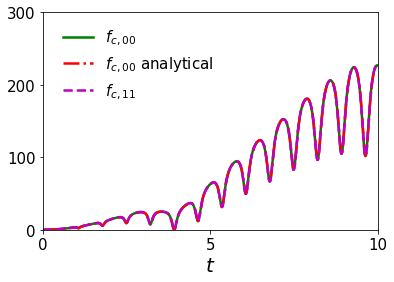

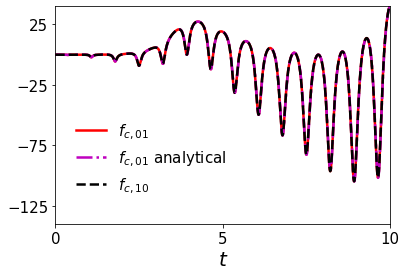

In [64]:
#==============noisy==============================
# analytical solution
gamma = 2*gamma1
delta_p = lambda t: np.cos(2*t*(x1+x2))**2/(np.exp(2*gamma*t)-np.sin(2*t*(x1+x2))**2)
delta_m = lambda t: np.cos(2*t*(x1-x2))**2/(np.exp(2*gamma*t)-np.sin(2*t*(x1-x2))**2)
t = np.linspace(0, T, tnum)
plt.plot(np.linspace(0, T, tnum), fc00, 'g-', linewidth=2.5, label='$f_{c,00}$')
plt.plot(np.linspace(0, T, tnum), 2*t**2*(delta_p(t)+delta_m(t)), 'r-.', linewidth=2.5, label='$f_{c,00}~$analytical')
plt.plot(np.linspace(0, T, tnum), fc11, 'm--', linewidth=2.5, label='$f_{c,11}$')

plt.xlabel('$t$',fontsize=20)
plt.axis([0, 10., 0, 300])
plt.xticks([0,5,10],fontsize=15)
plt.yticks([0,100,200,300],fontsize=15)
plt.legend(bbox_to_anchor = [0.55, 0.53], frameon=False,fontsize=15)
plt.show()

plt.plot(np.linspace(0, T, tnum), fc01, 'r-', linewidth=2.5, label='$f_{c,01}$')
plt.plot(np.linspace(0, T, tnum), 2*t**2*(delta_p(t)-delta_m(t)), 'm-.', linewidth=2.5, label='$f_{c,01}~$analytical')
plt.plot(np.linspace(0, T, tnum), fc10, 'k--', linewidth=2.5, label='$f_{c,10}$')

plt.xlabel('$t$',fontsize=20)
plt.axis([0, 10., -140, 40])
plt.xticks([0,5,10],fontsize=15)
plt.yticks([-125, -75,-25,25],fontsize=15)
plt.legend(bbox_to_anchor = [0.55, 0.53], frameon=False,fontsize=15)
plt.show()

annalytical result

In [23]:
psi00 = np.kron(psi0,psi0)
psi01 = np.kron(psi0,psi1)
psi10 = np.kron(psi1,psi0)
psi_ana = lambda t: (np.exp(1.j*2*x2*t)*psi00+1.j*np.cos(2*x1*t)*psi01-np.sin(2*x1*t)*psi10)/np.sqrt(2)
dpsi_ana = lambda t: (-2*1.j*t*np.sin(2*x1*t)*psi01-2*t*np.cos(2*x1*t)*psi10)/np.sqrt(2)

t = np.linspace(0, T, tnum)
rho_ana = []
rho_ana = []
for ii in range(tnum):
    psi_tp = psi_ana(t[ii])
    psi_dag = psi_ana(t[ii]).conj().transpose()
    dpsi_tp = dpsi_ana(t[ii])
    dpsi_dag = dpsi_ana(t[ii]).conj().transpose()
    rho_tp = np.dot(psi_tp, psi_tp.conj().transpose())
    drho_tp = np.dot(dpsi_tp, psi_dag)+np.dot(psi_tp, dpsi_dag)
    rho_ana.append(rho_tp)
    drho_ana.append(drho_tp)
#-----------------------------------------------------
P1_ana = lambda t: 0.25*(1-np.sin(2*(x1-x2)*t))
P2_ana = lambda t: 0.25*(1-np.sin(2*(x1+x2)*t))
P3_ana = lambda t: 0.25*(1+np.sin(2*(x1+x2)*t))
P4_ana = lambda t: 0.25*(1+np.sin(2*(x1-x2)*t))

dP1_ana = lambda t: -0.5*(t*np.cos(2*(x1-x2)*t))
dP2_ana = lambda t: -0.5*(t*np.cos(2*(x1+x2)*t))
dP3_ana = lambda t: 0.5*(t*np.cos(2*(x1+x2)*t))
dP4_ana = lambda t: 0.5*(t*np.cos(2*(x1-x2)*t))


For single-qubit systems, the QFIM in the Bloch representation can be expressed as
$F_{ab}=(\partial_{x_a} \vec{r})\cdot(\partial_{x_b} \vec{r})+\frac{(\vec{r}\cdot \partial_{x_a}\vec{r})(\vec{r}\cdot \partial_{x_b}\vec{r})}{1-|\vec{r}|^2}$,

For pure state, it can be reduced to
$F_{ab}=(\partial_{x_a} \vec{r})\cdot(\partial_{x_b} \vec{r})$.

For example

$\vec{r}=(\sin\theta\cos\phi, \sin\theta\sin\phi, \cos\theta)$

$\partial_{\theta}\vec{r}=(\cos\theta\cos\phi, \cos\theta\sin\phi, -\sin\theta)$

$\partial_{\phi}\vec{r}=(-\sin\theta\sin\phi, \sin\theta\cos\phi, 0)$

In [51]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt

from AsymptoticBound.CramerRao import CramerRao

eta = 0.8
theta_span = np.linspace(0, np.pi, 50)
phi_span = np.linspace(0, 2*np.pi, 50)

CRB = CramerRao()
F = []
theta_all = []
for theta in theta_span:
    for phi in phi_span:
        r = np.array([0.,0.,0.])
        r[0] = eta*np.sin(theta)*np.cos(phi)
        r[1] = eta*np.sin(theta)*np.sin(phi)
        r[2] = eta*np.cos(theta)

        dr_theta = np.array([0.,0.,0.])
        dr_theta[0] = eta*np.cos(theta)*np.cos(phi)
        dr_theta[1] = eta*np.cos(theta)*np.sin(phi)
        dr_theta[2] = -eta*np.sin(theta)
        
        dr_phi = np.array([0.,0.,0.])
        dr_phi[0] = -eta*np.sin(theta)*np.sin(phi)
        dr_phi[1] = eta*np.sin(theta)*np.cos(phi)
        dr_phi[2] = 0.
        
        dr = [dr_theta, dr_phi]
        F_tp = CRB.QFIM_Bloch(r, dr, dtype='SLD', rep='original', exportLD=False)
        
        F.append(F_tp)
        theta_all.append(theta)

F_theta = [F[i][0][0] for i in range(len(F))]
F_theta_phi = [F[i][0][1] for i in range(len(F))]
F_phi_theta = [F[i][1][0] for i in range(len(F))]
F_phi = [F[i][1][1] for i in range(len(F))]

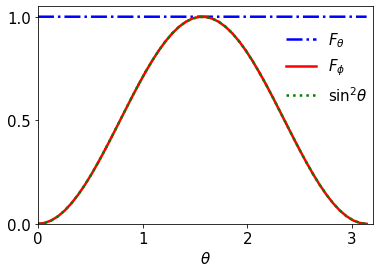

In [49]:
#==========================unitary===========================
plt.plot(theta_all, F_theta, 'b-.',linewidth=2.5, label='$F_{\\theta}$')
plt.plot(theta_all, F_phi, 'r-', linewidth=2.5, label='$F_{\\phi}$')
plt.plot(theta_all, np.sin(theta_all)**2, 'g:',linewidth=2.5,  label='$\mathrm{sin}^2\\theta$')
plt.axis([0,3.2,0,1.05])
plt.xticks([0,1,2,3],fontsize=15)
plt.yticks([0,0.5,1.0],fontsize=15)
plt.xlabel('$\\theta$', fontsize=15)
plt.legend(bbox_to_anchor = [0.70, 0.72], frameon=False,fontsize=15)

plt.show()

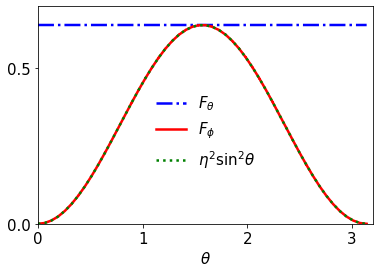

In [67]:
#==========================noisy===========================
plt.plot(theta_all, F_theta, 'b-.',linewidth=2.5, label='$F_{\\theta}$')
plt.plot(theta_all, F_phi, 'r-', linewidth=2.5, label='$F_{\\phi}$')
plt.plot(theta_all, eta**2*np.sin(theta_all)**2, 'g:',linewidth=2.5,  label='$\\eta^2\mathrm{sin}^2\\theta$')

plt.axis([0,3.2,0,0.7])
plt.xticks([0,1,2,3],fontsize=15)
plt.yticks([0,0.5],fontsize=15)
plt.xlabel('$\\theta$', fontsize=15)
plt.legend(bbox_to_anchor = [0.50, 0.66], frameon=False,fontsize=15)
plt.show()

In [11]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
from AsymptoticBound.CramerRao import QFIM, CFIM

#============================
# for single-qubit systems
#============================
def F_single_qubit(r, dr):
    para_num = len(dr)
    QFIM_res = np.zeros([para_num,para_num])
    norm2 = LA.norm(r)**2
    if np.abs(norm2 - 1)<1e-6:
        for para_i in range(0, para_num):
            for para_j in range(para_i, para_num):
                QFIM_res[para_i][para_j] = np.inner(dr[para_i],dr[para_j])
                QFIM_res[para_j][para_i] = QFIM_res[para_i][para_j]
    else:
        for para_i in range(0, para_num):
            for para_j in range(para_i, para_num):
                QFIM_res[para_i][para_j] = np.inner(dr[para_i],dr[para_j])+np.inner(r,dr[para_i])*\
                                              np.inner(r,dr[para_j])/(1-norm2)
                QFIM_res[para_j][para_i] = QFIM_res[para_i][para_j]
    if para_num == 1:
        return QFIM_res[0][0]
    else: 
        return QFIM_res
        
eta = 0.8
theta_span = np.linspace(0, np.pi, 50)
phi_span = np.linspace(0, 2*np.pi, 50)

F = []
F_ = []
theta_all = []
for theta in theta_span:
    for phi in phi_span:
        r = np.array([0.,0.,0.])
        r[0] = eta*np.sin(theta)*np.cos(phi)
        r[1] = eta*np.sin(theta)*np.sin(phi)
        r[2] = eta*np.cos(theta)

        dr_theta = np.array([0.,0.,0.])
        dr_theta[0] = eta*np.cos(theta)*np.cos(phi)
        dr_theta[1] = eta*np.cos(theta)*np.sin(phi)
        dr_theta[2] = -eta*np.sin(theta)
        
        dr_phi = np.array([0.,0.,0.])
        dr_phi[0] = -eta*np.sin(theta)*np.sin(phi)
        dr_phi[1] = eta*np.sin(theta)*np.cos(phi)
        dr_phi[2] = 0.
        
        dr = [dr_phi,dr_theta]
        f = F_single_qubit(r, dr)    #for SLD-type QFI
        F_tp_ = QFIM(r, dr, dtype='SLD', rep='original', rho_type = 'Bloch_vector', exportLD=False)
        
        F.append(f)
        F_.append(F_tp_)
        theta_all.append(theta)

F_theta = [F[i][0][0] for i in range(len(F))]
F_theta_phi = [F[i][0][1] for i in range(len(F))]
F_phi_theta = [F[i][1][0] for i in range(len(F))]
F_phi = [F[i][1][1] for i in range(len(F))]

F_theta_ = [F_[i][0][0] for i in range(len(F_))]
F_theta_phi_ = [F_[i][0][1] for i in range(len(F_))]
F_phi_theta_ = [F_[i][1][0] for i in range(len(F_))]
F_phi_ = [F_[i][1][1] for i in range(len(F_))]

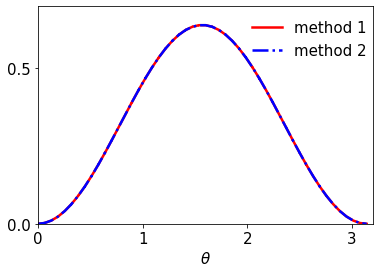

In [15]:
plt.plot(theta_all, F_theta, 'r-',linewidth=2.5, label='method 1')
plt.plot(theta_all, F_theta_, 'b-.',linewidth=2.5, label='method 2')

plt.axis([0,3.2,0,0.7])
plt.xticks([0,1,2,3],fontsize=15)
plt.yticks([0,0.5],fontsize=15)
plt.xlabel('$\\theta$', fontsize=15)
plt.legend(bbox_to_anchor = [0.60, 0.7], frameon=False,fontsize=15)
plt.show()

# QuanEstimation : QFI based on RLD (LLD)

We consider a system whose Hamiltonian is $H = \frac{1}{2}\omega_0 \sigma_z$, where $\sigma_z$ is a Pauli matrix.

The dynamics of the system is governed by
$\partial_t\rho=-i[H, \rho]+ \frac{\gamma}{2}(\sigma_z\rho\sigma_z-\rho)$.

Preparing the probe state at $|+\rangle$.

[1] J. Liu and H. Yuan, Phys. Rev. A $\textbf{96}$, 012117 (2017).

In [16]:
%reset -f
import numpy as np
from scipy import linalg as scylin
import matplotlib.pyplot as plt
import julia
from julia import Main

from AsymptoticBound.CramerRao import QFIM
from Common.common import mat_vec_convert, dRHO

Main.include('./'+'Common'+'/'+'Liouville.jl')

omega0 = 1.0
gamma_p = 0.05
T = 30.0
dt = 0.01
tnum = int(T/dt)
sx = np.array([[0.+0.j, 1.+0.j],[1.+0.j, 0.+0.j]])  
sy = np.array([[0.+0.j, 0.-1.j],[0.+1.j, 0.+0.j]]) 
sz = np.array([[1.+0.j, 0.+0.j],[0.+0.j, -1.+0.j]])
sp, sm = 0.5*(sx+1j*sy), 0.5*(sx-1j*sy)

#initial state
psi0 = np.array([[1.+0.j],[0.+0.j]])
psi1 = np.array([[0.+0.j],[1.+0.j]])
psi_p = (psi0+psi1)/np.sqrt(2)
psi_m = (psi0-psi1)/np.sqrt(2)
rho0 = np.dot(psi_p, psi_p.conj().T)
dim = len(rho0)

#time independent Hamiltonian
H = 0.5*omega0*sz
dH = 0.5*sz

# Hilbert space to liouvillian
H_L = Main.Liouville.liouville_commu(H)
dH_L = Main.Liouville.liouville_commu(dH)
sz_L  = Main.Liouville.liouville_dissip(sz)

#measurement
M1 = np.dot(psi_p, psi_p.conj().transpose())
M2 = np.dot(psi_m, psi_m.conj().transpose())
M  = [M1, M2]

state_pre = mat_vec_convert(rho0)
d_state = np.array([[0.+0.*1.j] for i in range(0,dim**2)])
Liouv_tot = -1j*H_L + gamma_p*sz_L

F_s, F_r, F_l = [], [], []
FB_s, FB_r, FB_l = [], [], []
for ti in range(tnum):
     
    state = np.dot(scylin.expm(dt*Liouv_tot), state_pre)
    rho = mat_vec_convert(state)
    
    A = -1j*np.dot(dH_L, state_pre)
    d_state = dRHO(d_state, Liouv_tot, A, dt)
    
    d_rho = mat_vec_convert(d_state)
    drho = [d_rho]
    f_s = QFIM(rho, drho, dtype='SLD')
    f_r = QFIM(rho, drho, dtype='RLD')
    f_l = QFIM(rho, drho, dtype='LLD')
    
    rxt = np.trace(np.dot(rho,sx))
    ryt = np.trace(np.dot(rho,sy))
    rzt = np.trace(np.dot(rho,sz))
    
    drxt = np.trace(np.dot(d_rho,sx))
    dryt = np.trace(np.dot(d_rho,sy))
    drzt = np.trace(np.dot(d_rho,sz))
    
    r = [rxt, ryt, rzt]
    dr = [[drxt, dryt, drzt]]
    fb_s = QFIM(r, dr, dtype='SLD', rep='original', rho_type = 'Bloch_vector', exportLD=False)
    fb_r = QFIM(r, dr, dtype='RLD', rep='original', rho_type = 'Bloch_vector', exportLD=False)
    fb_l = QFIM(r, dr, dtype='LLD', rep='original', rho_type = 'Bloch_vector', exportLD=False)
    state_pre = state
    
    F_s.append(f_s)
    F_r.append(f_r)
    F_l.append(f_l)
    FB_s.append(fb_s)
    FB_r.append(fb_r)
    FB_l.append(fb_l)


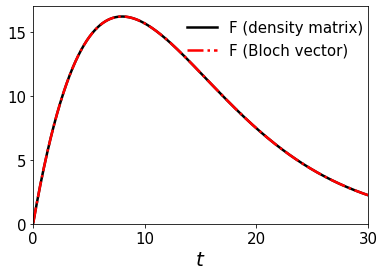

In [35]:
#plt.plot(np.linspace(0, T, tnum), F_s, 'r-', linewidth=2.5, label='F (density matrix)')
#plt.plot(np.linspace(0, T, tnum), FB_s, 'g--', linewidth=2.5, label='F (Bloch vector)')

#plt.plot(np.linspace(0, T, tnum), F_r, 'b-', linewidth=2.5, label='F (density matrix)')
#plt.plot(np.linspace(0, T, tnum), FB_r, 'm-.', linewidth=2.5, label='F (Bloch vector)')

plt.plot(np.linspace(0, T, tnum), F_l, 'k-', linewidth=2.5, label='F (density matrix)')
plt.plot(np.linspace(0, T, tnum), FB_l, 'r-.', linewidth=2.5, label='F (Bloch vector)')
plt.xlabel('$t$',fontsize=20)
plt.axis([0, 30., 0, 17])
plt.xticks([0,10,20,30],fontsize=15)
plt.yticks([0,5,10,15],fontsize=15)
plt.legend(bbox_to_anchor = [0.42, 0.7], frameon=False,fontsize=15)
plt.savefig('test_qfi.pdf',bbox_inches = 'tight')
plt.show()

In [ ]:
%reset -f
import numpy as np
from scipy import linalg as scylin
import matplotlib.pyplot as plt
import julia
from julia import Main

from AsymptoticBound.CramerRao import CramerRao
from Common.common import mat_vec_convert, dRHO

Main.include('./'+'Common'+'/'+'Liouville.jl')

omega0 = 1.0
gamma_p = 0.05
T = 30.0
dt = 0.01
tnum = int(T/dt)
sx = np.array([[0.+0.j, 1.+0.j],[1.+0.j, 0.+0.j]])  
sy = np.array([[0.+0.j, 0.-1.j],[0.+1.j, 0.+0.j]]) 
sz = np.array([[1.+0.j, 0.+0.j],[0.+0.j, -1.+0.j]])
sp, sm = 0.5*(sx+1j*sy), 0.5*(sx-1j*sy)

#initial state
psi0 = np.array([[1.+0.j],[0.+0.j]])
psi1 = np.array([[0.+0.j],[1.+0.j]])
psi_p = (psi0+psi1)/np.sqrt(2)
psi_m = (psi0-psi1)/np.sqrt(2)
rho0 = np.dot(psi_p, psi_p.conj().T)
dim = len(rho0)

rx0 = np.trace(np.dot(rho, sx))
ry0 = np.trace(np.dot(rho, sy))
rz0 = np.trace(np.dot(rho, sz))

rxt = lambda t: np.exp(-gamma*t)*(np.cos(omega*t)*rx0-np.sin(omega*t)*ry0)
rxt = lambda t: np.exp(-gamma*t)*(np.cos(omega*t)*ry0+np.sin(omega*t)*rx0)
rzt = rz0

drxt = lambda t: np.exp(-gamma*t)*(-t*np.sin(omega*t)*rx0-t*np.cos(omega*t)*ry0)
drxt = lambda t: np.exp(-gamma*t)*(-t*np.sin(omega*t)*ry0+t*np.cos(omega*t)*rx0)
drzt = 0

